In [33]:
import numpy as np
import pandas as pd

from ResearchMain import *
from sklearn.decomposition import PCA
from scipy.stats import zscore

## 数据准备

### 演示数据集
泰坦尼克号数据结构分析：
- Pclass:乘客所持票类，有三种值(1：lower,2：middle,3：upper)
- Survived:0代表死亡，1代表存活
- Name:乘客姓名
- Sex:乘客性别(男：1，女：0)
- Age:乘客年龄(缺失值取平均值)
- SibSp:乘客兄弟姐妹/配偶的个数(整数值)
- Parch:乘客父母/孩子的个数(整数值)
- Ticket:票号(字符串)
- Fare:乘客所持票的价格(浮点数，0-500不等)
- Cabin:乘客所在船舱
- Embark:乘客登船港口:S、C、Q

In [4]:
# 读取演示数据集
# demo_data_name = 'pca_demo_titanic.csv'
# demo_data = pd.read_csv(DATA_PATH+demo_data_name, index_col='PassengerId')
# data.head(3)


In [5]:
# df = demo_data

### 读取分析数据

In [6]:
_ = all_df[[i for i in all_df.columns if
            isinstance(i, str) and (i.startswith('S') or i.endswith('-Ф'))]].replace(0, 0.00001)
sediment_df = _.drop(['S-Size-d((0.9-0.1)/0.5)', 'S-pH'], axis=1)

water_df = all_df[[i for i in all_df.columns if
                   isinstance(i, str) and i.startswith('W')]].replace(0, 0.00001)
water_df = water_df.drop(['W-PO_{4}^{3-}', 'W-TP'], axis=1)

df = water_df
df

,W-pH,W-DO,W-TN,W-NO_{2}^{-},W-NO_{3}^{-},W-NH_{4}^{+},W-COD,W-T
D-N1,8.10,10.66,3.9899,0.27990,0.330000,2.980000,14.27,11.3
D-N2,8.00,10.02,3.7400,0.09160,0.300000,2.740000,14.13,12.5
D-N3,8.10,10.58,3.6200,0.10250,0.290000,2.827500,15.44,14.7
D-N4,7.84,10.62,3.8600,0.20900,0.250000,2.810000,15.01,13.8
D-N5,7.90,11.06,3.7500,0.18070,0.260000,2.790000,16.52,13.6
...,...,...,...,...,...,...,...,...
W-H8,9.11,9.14,1.9000,0.00001,0.051411,0.667800,10.94,20.4
W-H9,8.79,8.82,1.3800,0.00001,0.008870,1.085500,11.92,22.6
W-H10,9.17,9.74,1.3300,0.00001,0.030141,1.299859,11.11,21.4
W-H11,9.14,9.78,1.6300,0.00001,0.004616,1.422200,11.13,22.0


## PCA分析

注意点：

1. 上面经过数据准备后，最后进行PCA分析的数据矩阵应命名为df；
2. 数据表不可以有空值；

### 预检验

首先进行KMO和Bartlett的检验，判断是否可以进行主成分分析。 对于KMO值：0.8上非常合适做主成分分析，0.7-0.8之间一般适合，0.6-0.7之间不太适合，0.5-0.6之间表示差，0.5下表示极不适合，对于 Bartlett的检验（p < 0.05,严格来说p < 0.01），若显著性小于0.05或0.01，拒绝原假设，则说明可以做主成分分析，若不拒绝原假设，则说明这些变量可能独立提供一些信息，不适合做主成分分析；

In [7]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# 巴特利特P值小于0.01，KMO值大于0.6；说明此数据适合做因子分析。
chi_square_value, p_value = calculate_bartlett_sphericity(df)  # 计算巴特利特P值
p_value

9.894740568791015e-71

In [8]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)
kmo_model

0.7980135965340764

<AxesSubplot:>

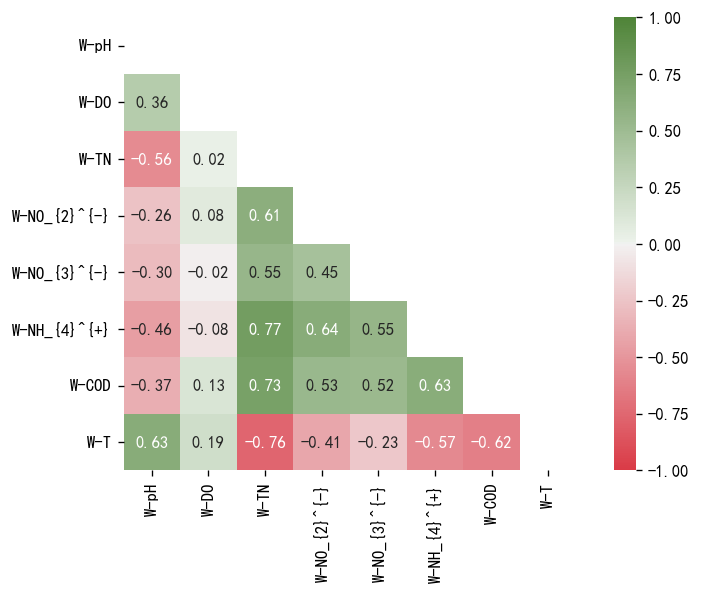

In [9]:
# 查看数据各列之间的相关性
matrix = df.corr()  # 获取各列之间的相关性，这个matrix其实就是X的协方差矩阵
mask = np.triu(np.ones_like(matrix, dtype=bool))  # mask掉上三角部分
plt.figure(figsize=(8, 5), dpi=120)
cmap = sns.diverging_palette(370, 120, n=80, as_cmap=True)
sns.heatmap(matrix, mask=mask, center=0, cmap=cmap, annot=True,
            square=True, fmt='.2f', vmax=1, vmin=-1)
# plt.title('泰坦尼克号数据集各列之间的相关性')

### 数据标准化

In [10]:
# 数据矩阵标准化与中心化
X = (df - df.mean()) / df.std(ddof=0)

这一步是主成分分析（PCA）的数据预处理，首先计算出矩阵中每一列的平均值，然后让每一列中的每一个元素都减去该列的平均值。在进行完这一步之后可以观察每一列数据的分散情况，如果列与列之间的差距仍过大，可以再计算出每一列的方差，然后再将减去平均值后的结果除以每一列的方差（这一步是可选步骤，叫做方差归一化）。

如果两步都做了，这个叫做数据的normalization——对一个非标准的正态分布随机变量转化为标准的正态分布随机变量。

这里一个注意点：
我们使用ddof=1样本标准偏差或ddof=0总体标准偏差作为参数来控制。

### 算法降维处理
在选取特征值的时候，要选取比较大的，特征值大的话数据方差就大，这也就意味着在经过降维后，可以最大程度上保留数据的差异性。

降维的过程实际就是寻找投影方向的过程。

从一个方面讲:

- 好的投影方向，可以使得投影误差最小化。
- 投影误差是各个数据点到投影点距离，这也就意味着经过降维处理后的损失达到最小。

从另一个方面讲:

- 好的投影方向，也就意味着在该方向投影的方差应该最大(分散度/区分度高)，可是使得信息在最大程度上得到保留。
- 复原误差小、重建容易。

降维的步骤：

目标：将n维数据降低为k维(k<n)。
（1）计算协方差矩阵：协方差矩阵（n×n）其实就是原数据矩阵中每两列之间的相关性系数；
（2）计算投影方向：对E进行奇异值分解(Singular Value Decomposition) [U,S,V] = svd (SIGMA)

其中U是一个nxn的矩阵，它每列是SIGMA的一个特征向量(线性代数概念)，U的前k列就是PCA的前k个投影向;我们将U的前k列记为投影矩阵P.
U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0

计算投影：

- 上一步我们得到了投影矩阵$P \in R^{n \times k}$；
- 对于第i个n维样本$x^{(i)}$，计算$z^{(i)} = x^{(i)} * P$，$z^{(i)}$就是降维后的第i个样本。

$$
X \in R^{m \times n} \times P \in R^{n \times k} = Z \in R^{m \times k}
$$


In [32]:
# X.to_csv('C:\\Users\\myxc\\Desktop\\demo_std.csv')
X

var,W-pH,W-DO,W-TN,W-NO_{2}^{-},W-NO_{3}^{-},W-NH_{4}^{+},W-COD,W-T
D-N1,-0.431864,1.017856,2.484114,4.191561,2.584494,2.514196,1.619199,-1.772812
D-N2,-0.591550,0.571570,2.116544,0.768953,2.193395,2.091432,1.487378,-1.521581
D-N3,-0.431864,0.962070,1.940040,0.967075,2.063029,2.245565,2.720844,-1.060989
D-N4,-0.847049,0.989963,2.293048,2.902857,1.541564,2.214738,2.315966,-1.249413
D-N5,-0.751237,1.296784,2.131252,2.388466,1.671930,2.179508,3.737748,-1.291285
...,...,...,...,...,...,...,...,...
W-H8,1.180971,-0.042072,-0.589854,-0.895820,-1.047360,-1.558783,-1.516253,0.132362
W-H9,0.669974,-0.265214,-1.354705,-0.895820,-1.601951,-0.822998,-0.593508,0.592953
W-H10,1.276783,0.376321,-1.428248,-0.895820,-1.324655,-0.445401,-1.356185,0.341722
W-H11,1.228877,0.404214,-0.986988,-0.895820,-1.657410,-0.229895,-1.337354,0.467338


In [12]:
# SIGMA  # 各列之间的相关性（可以查看上面使用X.corr()命令获取矩阵X中各列之间的相关性所绘制的热图中的数据其实就是计算了矩阵X的协方差）
# 计算协方差矩阵（代表原矩阵中各列之间的相关性），@用来计算矩阵之间的乘法，.shape[0]获取矩阵中有多少行
SIGMA = (X.T @ X) / X.shape[0]
# 奇异值分解
U, S, V = np.linalg.svd(SIGMA)  # S 是个对角矩阵，是特征值，U是特征值对应的标准正交特征向量
# U
P = U[:, :2]  # 这里取U的前两列就是前两个投影的方向
# P
Z = X @ P  # Z就是经过降维后的矩阵
Z

,0,1
D-N1,5.839584,-2.321331
D-N2,4.112343,-0.917081
D-N3,4.368839,-1.680056
D-N4,5.063841,-1.803784
D-N5,5.374656,-2.231411
...,...,...
W-H8,-2.576255,0.309734
W-H9,-2.428168,0.514359
W-H10,-2.642376,-0.103593
W-H11,-2.485412,-0.109026


In [13]:
X = (df - df.mean()) / df.std(ddof=0)  # 获取经过Normalization的矩阵X
SIGMA = (X.T @ X) / X.shape[0]

# X.corr()
SIGMA  # SIGMA其实就是X.corr()


,W-pH,W-DO,W-TN,W-NO_{2}^{-},W-NO_{3}^{-},W-NH_{4}^{+},W-COD,W-T
W-pH,1.000000,0.356634,-0.560777,-0.257999,-0.302546,-0.456350,-0.373631,0.634866
W-DO,0.356634,1.000000,0.024845,0.080646,-0.019796,-0.078357,0.126312,0.193316
W-TN,-0.560777,0.024845,1.000000,0.610175,0.545254,0.769003,0.734937,-0.762336
W-NO_{2}^{-},-0.257999,0.080646,0.610175,1.000000,0.449292,0.638340,0.525036,-0.411917
W-NO_{3}^{-},-0.302546,-0.019796,0.545254,0.449292,1.000000,0.550762,0.518713,-0.229810
W-NH_{4}^{+},-0.456350,-0.078357,0.769003,0.638340,0.550762,1.000000,0.625538,-0.565611
W-COD,-0.373631,0.126312,0.734937,0.525036,0.518713,0.625538,1.000000,-0.621128
W-T,0.634866,0.193316,-0.762336,-0.411917,-0.229810,-0.565611,-0.621128,1.000000


In [14]:
# V
# ew, ev = np.linalg.eig(X.T.dot(X))
ew, ev = np.linalg.eig(np.cov(X.T))  # ew: 特征值，ev: 特征向量
ew_order = np.argsort(ew)[::-1]  # 将ew按照从大到小的顺序排列
# 特征根，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。
ew_sort = ew[ew_order]
ev_sort = ev[:, ew_order]
print(ev_sort)

[[-3.17597692e-01 -4.77689791e-01  1.13252582e-01 -2.69313899e-01
  -6.69478393e-01  1.42586958e-01 -3.42126697e-01 -2.23843871e-03]
 [-4.21927260e-02 -7.39889332e-01 -4.32849359e-01  2.40100045e-01
   4.08123162e-01  9.64193637e-02 -1.73677795e-02 -1.72087487e-01]
 [ 4.49748800e-01 -5.15898529e-02 -1.54930852e-01  5.46783288e-02
   1.36181788e-02  1.97797701e-01 -3.88984226e-01  7.59903350e-01]
 [ 3.46037860e-01 -2.67404384e-01  1.64720672e-01 -7.15097345e-01
   2.44807958e-01 -4.58024632e-01 -2.15830775e-04 -2.31955778e-02]
 [ 3.13712454e-01 -1.94608772e-01  6.81822325e-01  4.85802139e-01
   4.13733148e-02 -1.29211815e-01 -3.09581080e-01 -2.20405607e-01]
 [ 4.15889252e-01 -6.14185761e-02  1.65224974e-01 -2.30492948e-01
  -2.69769564e-02  7.66962467e-01  3.09822569e-01 -2.40600066e-01]
 [ 3.95726969e-01 -2.02849458e-01 -1.77110704e-01  2.56120402e-01
  -5.30323637e-01 -3.33794439e-01  5.53755399e-01  7.73270433e-02]
 [-3.83869884e-01 -2.59647654e-01  4.74478282e-01  2.71970971e-02
   

### 方差解释表格
**图表说明:**
上表为总方差解释表格，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。一般情况下,方差解释率越高，说明该主成分越重要，权重占比也应该越高。

方差解释表中，在主成分4时，总方差解释的特征根低于1，变量解释的贡献率达到74.899%，以上仅为参考。
若特征根小于1临界值过大，也可以集合具体情况具体分析。

In [15]:
# 输出一个方差解释表格
var_inter_0 = pd.DataFrame({'特征值': ew_sort})  # 添加特征值列
var_inter_0['百分比'] = (var_inter_0 / var_inter_0.sum())  # 添加百分比列
var_inter_0['累计百分比'] = var_inter_0['百分比'].cumsum()  # 计算累计百分比
var_inter = var_inter_0.copy()
var_inter['累计百分比'] = var_inter['累计百分比'].apply(lambda x: format(x, '.1%'))  # 保留一位小数
# var_inter_0['1'] = 1  # 前两列特征值大于1，且51%以上可以用来解释原来7个变量，因此取前两列
var_inter

,特征值,百分比,累计百分比
0,4.299684,0.531489,53.1%
1,1.367079,0.168986,70.0%
2,0.794588,0.098220,79.9%
3,0.563506,0.069656,86.8%
4,0.404137,0.049956,91.8%
5,0.308063,0.038080,95.6%
6,0.231719,0.028643,98.5%
7,0.121113,0.014971,100.0%


In [16]:
var_inter.to_clipboard()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

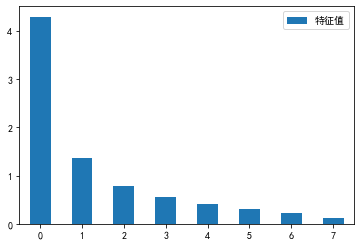

In [17]:
pd.DataFrame(ew_sort).plot(kind='bar').legend(
    ('特征值',))  # 添加图例必须多一个逗号，否则只显示第一个字符
plt.xticks(rotation=0)
# print(ev_sort)

In [18]:
# ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列# V
V = ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列
V

array([[-0.31759769, -0.47768979],
       [-0.04219273, -0.73988933],
       [ 0.4497488 , -0.05158985],
       [ 0.34603786, -0.26740438],
       [ 0.31371245, -0.19460877],
       [ 0.41588925, -0.06141858],
       [ 0.39572697, -0.20284946],
       [-0.38386988, -0.25964765]])

### 因子数据表

In [19]:
# 构建一个因子数据表
factor_load_table = pd.DataFrame(V)  # 因子载荷数据表，可以分析到每个主成分中隐变量的重要性。
factor_load_table.index = df.columns
factor_load_table.columns = ['PCA 0', 'PCA 1']
factor_load_table.index.name = 'var'
factor_load_table['公共度'] = factor_load_table['PCA 0'] ** 2 + factor_load_table[
    'PCA 1'] ** 2  # 公因子方差：每个变量对应的PCA0与PCA1的平方和
factor_load_table

,PCA 0,PCA 1,公共度
var,,,
W-pH,-0.317598,-0.477690,0.329056
W-DO,-0.042193,-0.739889,0.549216
W-TN,0.449749,-0.051590,0.204935
W-NO_{2}^{-},0.346038,-0.267404,0.191247
W-NO_{3}^{-},0.313712,-0.194609,0.136288
W-NH_{4}^{+},0.415889,-0.061419,0.176736
W-COD,0.395727,-0.202849,0.197748
W-T,-0.383870,-0.259648,0.214773


In [20]:
# 因子数据表的每一列的平方和相加等于1
factor_load_table.iloc[:,:2].applymap(lambda x: x**2).sum()

PCA 0    1.0
PCA 1    1.0
dtype: float64

In [21]:
# U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0
# (factor_load_table['PCA 0'] * factor_load_table['PCA 1']).sum()  # 两个特征向量的乘积应为0
# (factor_load_table['PCA 0']**2).sum()  # 每一个特征向量的模长都为1
# (factor_load_table['PCA 1']**2).sum()

<AxesSubplot:ylabel='var'>

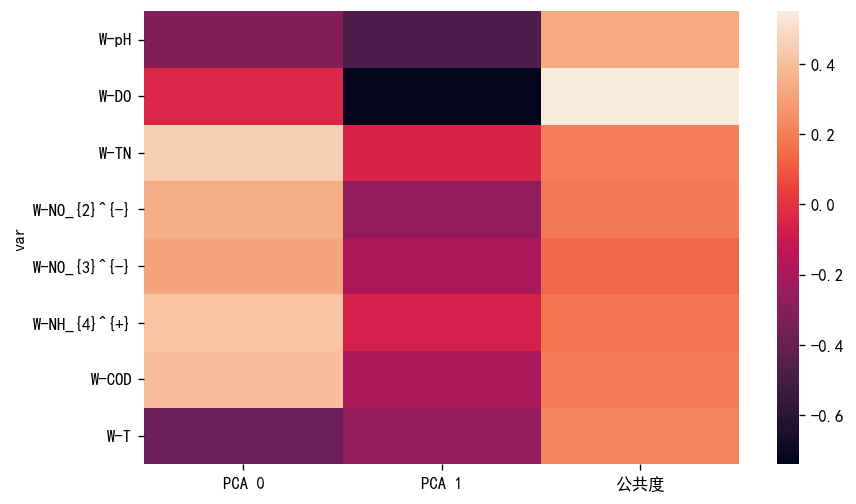

In [22]:
plt.figure(figsize=(8, 5), dpi=120)
sns.heatmap(factor_load_table)

### 绘图可视化

In [23]:
# X_new
X_new = X.dot(V)
# 将生存数据添加到DATaFrame中，用于绘制散点图的时候可以区分死亡与生存的区别
# X_new['Survived'] = train_data_0['Survived']
X_new

,0,1
D-N1,5.839584,-2.321331
D-N2,4.112343,-0.917081
D-N3,4.368839,-1.680056
D-N4,5.063841,-1.803784
D-N5,5.374656,-2.231411
...,...,...
W-H8,-2.576255,0.309734
W-H9,-2.428168,0.514359
W-H10,-2.642376,-0.103593
W-H11,-2.485412,-0.109026


<AxesSubplot:xlabel='PCA 0', ylabel='PCA 1'>

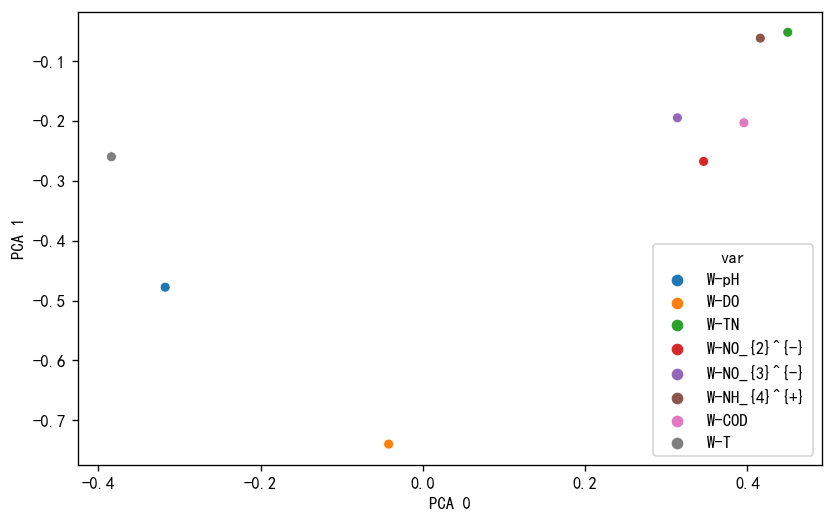

In [24]:
plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
sns.scatterplot(x=factor_load_table['PCA 0'],
                y=factor_load_table['PCA 1'], hue=factor_load_table.index)

### 成分矩阵表

In [25]:
# 成分矩阵表
composition_matrix = factor_load_table.loc[:, [
    'PCA 0', 'PCA 1']]  # 成分矩阵表 = 因子载荷数据表/对应每一个特征值
composition_matrix['PCA 0'] = composition_matrix['PCA 0'] / \
    ew_sort[0]  # 这里有个问题，有的软件里除的是根号下特征值，有的没有
composition_matrix['PCA 1'] = composition_matrix['PCA 1'] / ew_sort[1]
composition_matrix.round(3)

,PCA 0,PCA 1
var,,
W-pH,-0.074,-0.349
W-DO,-0.010,-0.541
W-TN,0.105,-0.038
W-NO_{2}^{-},0.080,-0.196
W-NO_{3}^{-},0.073,-0.142
W-NH_{4}^{+},0.097,-0.045
W-COD,0.092,-0.148
W-T,-0.089,-0.190


In [26]:
# composition_matrix.applymap(lambda x: x**2).sum()

图表说明：
上表为成分矩阵表，意在说明各个成分的所包含的因子得分系数（主成分载荷），用于计算出成分得分，得出因子公式，其计算公式为：线性组合系数*（方差解释率/累积方差解释率），最后将其归一化即为因子权重分。
线性组合系数，公式为：因子载荷系数除以对应特征根，即成分矩阵的系数。
智能分析：
模型的公式：
F1=-0.389×Pclass-0.254×Sex+0.099×Age+0.14×SibSp+0.214×Parch+0.45×Fare-0.212×Embarked
F2=0.262×Pclass-0.166×Sex-0.382×Age+0.411×SibSp+0.392×Parch-0.038×Fare+0.127×Embarked
由上可以得到：
F=(0.265/0.511)×F1+(0.245/0.511)×F2

### 因子权重分析表

In [27]:
factor_weight_analysis = pd.DataFrame(var_inter_0.loc[:1, ['百分比', '累计百分比']])
factor_weight_analysis['权重'] = factor_weight_analysis['百分比'] / \
    factor_weight_analysis['百分比'].sum()
factor_weight_analysis.index = ['PCA 0', 'PCA 1']
factor_weight_analysis.index.name = '主成分'
(factor_weight_analysis * 100).round(1).astype(str) + '%'  # 以保留一位小数、百分比的形式显示

,百分比,累计百分比,权重
主成分,,,
PCA 0,53.1%,53.1%,75.9%
PCA 1,16.9%,70.0%,24.1%


### 综合得分表（其实就是X_new中的数据）

In [28]:
comprehensive_score = pd.DataFrame(X_new.iloc[:, [0, 1]])
comprehensive_score.columns = ['PCA 0', 'PCA 1']
comprehensive_score['综合得分'] = comprehensive_score.iloc[:, 0] * factor_weight_analysis.loc[
    'PCA 0', '百分比'] + comprehensive_score.iloc[:, 1] * factor_weight_analysis.loc['PCA 1', '百分比']
comprehensive_score.sort_values(by='综合得分', ascending=False)  # 按照综合得分列倒序排列

,PCA 0,PCA 1,综合得分
D-N1,5.839584,-2.321331,2.711400
D-N5,5.374656,-2.231411,2.479492
D-N4,5.063841,-1.803784,2.386560
D-P1,4.015711,-0.255646,2.091104
D-N3,4.368839,-1.680056,2.038082
...,...,...,...
W-H12,-3.099563,-0.195059,-1.680345
W-P12,-2.355049,-2.882023,-1.738704
W-P11,-2.539278,-2.446231,-1.762977
W-P8,-2.407746,-3.074985,-1.799319


In [29]:
df.loc[comprehensive_score.sort_values(
    by='综合得分', ascending=False).head(5).index]  # 获取综合得分前五的人员

var,W-pH,W-DO,W-TN,W-NO_{2}^{-},W-NO_{3}^{-},W-NH_{4}^{+},W-COD,W-T
D-N1,8.10,10.66,3.9899,0.2799,0.33,2.9800,14.27,11.3
D-N5,7.90,11.06,3.7500,0.1807,0.26,2.7900,16.52,13.6
D-N4,7.84,10.62,3.8600,0.2090,0.25,2.8100,15.01,13.8
D-P1,7.47,9.95,3.9100,0.1199,0.20,2.3100,14.07,11.4
D-N3,8.10,10.58,3.6200,0.1025,0.29,2.8275,15.44,14.7


In [76]:
# 标准化
demo_df_std = zscore(gene_abundance.iloc[:,2:], ddof=1)
demo_df_std

Gene,AOA_amoA,AOB_amoA,nxrA,narG,napA,nirK,nirS,nosZ,norB,hzsA,hzsB,hzo,nifH
ID,,,,,,,,,,,,,
D-H1,-0.795439,-0.937835,-1.137722,-0.450554,-0.256669,-0.674825,-0.220976,-0.596444,-0.419935,-0.734460,-0.461042,-1.252559,-0.840610
D-H2,-0.873721,-0.882690,-1.138873,-0.467356,-0.532361,-0.665681,0.652727,-0.599384,-0.810940,-0.609016,-0.468489,-1.260703,-0.840892
D-H3,-1.169817,0.036094,-1.133688,-0.546952,-0.589798,-0.687748,4.103715,-0.597372,-0.809251,-0.627655,-0.440326,-1.319799,-0.842860
D-H4,-0.556729,0.306753,-1.135373,-0.619299,-0.636979,-0.689912,0.687616,-0.599713,-0.710485,-0.727336,-0.497158,-1.403723,-0.835846
D-H5,-0.853504,0.617796,-1.135192,-0.612103,-0.718548,-0.660290,2.122989,-0.597583,-0.732810,-0.704976,-0.499605,-1.413619,-0.836763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
W-P5,1.062522,0.395513,0.354735,-0.480421,-0.233360,1.084086,-0.127432,0.325595,0.369604,-0.546930,-0.247384,0.573940,-0.412118
W-P6,0.221768,-0.962847,1.503089,-0.502824,0.925694,0.107821,-0.420557,1.059534,0.894179,-0.308898,-0.355364,-0.308344,-0.063045
W-P7,-0.898978,-0.740817,1.360321,0.485719,-0.357265,-0.275077,-0.219501,-0.334992,2.262558,-0.122237,0.298247,0.088110,0.563432


In [77]:
md = PCA().fit(demo_df_std)

In [78]:
# 特征值
md.explained_variance_.round(3)

array([5.462, 1.519, 1.296, 1.169, 0.904, 0.725, 0.516, 0.45 , 0.269,
       0.234, 0.194, 0.143, 0.119])

In [79]:
# 各主成分贡献率
md.explained_variance_ratio_

array([0.42015038, 0.1168658 , 0.09969464, 0.0898866 , 0.06953277,
       0.05573654, 0.039693  , 0.03458508, 0.02072494, 0.01800469,
       0.01493742, 0.01099922, 0.0091889 ])

In [80]:
xs1 = md.components_
check = xs1.sum(axis=1, keepdims=True)
xs2 = xs1*np.sign(check)
xs2.round(3)

array([[ 0.345,  0.063,  0.306,  0.256,  0.226,  0.346, -0.134,  0.384,
         0.289,  0.281,  0.308,  0.189,  0.299],
       [ 0.317,  0.26 , -0.066, -0.379, -0.175,  0.244,  0.433,  0.175,
        -0.095, -0.101,  0.383, -0.433, -0.144],
       [-0.068,  0.58 ,  0.187,  0.101,  0.481, -0.055, -0.009, -0.059,
         0.214,  0.112, -0.265, -0.239, -0.436],
       [-0.001, -0.37 , -0.203,  0.441,  0.152, -0.159,  0.564,  0.051,
         0.154,  0.273, -0.108, -0.371,  0.107],
       [-0.01 ,  0.156, -0.406,  0.088,  0.252,  0.32 ,  0.288,  0.168,
         0.108, -0.56 , -0.252,  0.345,  0.136],
       [-0.198,  0.456, -0.069,  0.234, -0.572, -0.145,  0.024, -0.105,
         0.492, -0.049,  0.072, -0.06 ,  0.282],
       [ 0.033,  0.441, -0.16 ,  0.243, -0.081, -0.082,  0.196,  0.026,
        -0.642,  0.392, -0.011,  0.297,  0.11 ],
       [-0.234, -0.066,  0.563, -0.165, -0.074, -0.168,  0.565,  0.075,
         0.111, -0.025,  0.041,  0.447, -0.153],
       [-0.113, -0.061, -0.524, 

In [71]:
# 验证PCA结果
pd.DataFrame(xs2).applymap(lambda x: x**2).sum(axis=0)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
dtype: float64

In [72]:
np.sum(pd.DataFrame(xs2).iloc[0,:] * pd.DataFrame(xs2).iloc[1,:])

-6.938893903907228e-18